<a href="https://colab.research.google.com/github/Aryanupadhyay23/LightGBM/blob/main/Catboost_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries installation

In [51]:
!pip install catboost
!pip install ipywidgets
!pip install shap
!pip install sklearn
!jupyter nbextension enable --py widgetsnbextension

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [52]:
import os
import pandas as pd
import numpy as np

import catboost
print(catboost.__version__)

1.2.8


## Reading the data

In [53]:
df = pd.read_csv('https://gist.githubusercontent.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41/raw/d42d226d0dd64e7f5395a0eec1b9190a10edbc03/Medical_Cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [54]:
df.shape

(1338, 7)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Exploring the data

In [56]:
y = df['charges']
X = df.drop('charges', axis=1)

In [57]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


Categorical features declaration

In [58]:
cat_features = [1,3,4,5]
print(cat_features)

[1, 3, 4, 5]


# Training the first model

In [59]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=10)

model.fit(X, y, cat_features=cat_features, verbose=5)

Learning rate set to 0.5
0:	learn: 7787.0489866	total: 1.4ms	remaining: 12.6ms
5:	learn: 4560.8501449	total: 5.38ms	remaining: 3.59ms
9:	learn: 4380.1688426	total: 9.26ms	remaining: 0us


In [60]:
model.predict(X)

array([19654.86890676,  4327.79540466,  6394.05757217, ...,
        3133.7350406 ,  2861.55162174, 34285.14154651])

# Working with dataset

There are several ways of passing dataset to training - using X,y (the initial matrix) or using Pool class.
Pool class is the class for storing the dataset. In the next few blocks we'll explore the ways to create a Pool object.

You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.

In [61]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)

## Split your data into train and validation

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

## Selecting the objective function

In [63]:
model = CatBoostRegressor(
    iterations=5,
    learning_rate=0.1,
    loss_function='RMSE'
)
model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'RMSE'}


## Stdout of the training

In [64]:
model = CatBoostRegressor(
    iterations=15,
    verbose=5,
)
model.fit(train_pool, eval_set=validation_pool);

Learning rate set to 0.5
0:	learn: 7608.2906506	test: 7667.5765651	best: 7667.5765651 (0)	total: 742us	remaining: 10.4ms
5:	learn: 4604.5635186	test: 4106.7789446	best: 4106.7789446 (5)	total: 5.09ms	remaining: 7.64ms
10:	learn: 4429.2010329	test: 4065.7452484	best: 4039.2627286 (8)	total: 8.1ms	remaining: 2.95ms
14:	learn: 4259.1387065	test: 4064.9212176	best: 4039.2627286 (8)	total: 11.5ms	remaining: 0us

bestTest = 4039.262729
bestIteration = 8

Shrink model to first 9 iterations.


## Metrics calculation and graph plotting

In [65]:
model = CatBoostRegressor(
    iterations=50,
    learning_rate=0.5,
    loss_function='RMSE'
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [66]:
model1 = CatBoostRegressor(
    learning_rate=0.7,
    iterations=100,
    train_dir='salman'
)

model2 = CatBoostRegressor(
    learning_rate=0.01,
    iterations=100,
    train_dir='shahrukh'
)

model1.fit(train_pool, eval_set=validation_pool, verbose=20)
model2.fit(train_pool, eval_set=validation_pool, verbose=20)

0:	learn: 6225.1861330	test: 6028.1142804	best: 6028.1142804 (0)	total: 732us	remaining: 72.5ms
20:	learn: 4064.4776624	test: 4230.9297514	best: 4166.3947766 (10)	total: 21.1ms	remaining: 79.3ms
40:	learn: 3595.5874566	test: 4293.5019510	best: 4166.3947766 (10)	total: 41.2ms	remaining: 59.3ms
60:	learn: 3118.0919822	test: 4405.3245592	best: 4166.3947766 (10)	total: 61.9ms	remaining: 39.6ms
80:	learn: 2816.0249682	test: 4386.6941790	best: 4166.3947766 (10)	total: 82.4ms	remaining: 19.3ms
99:	learn: 2551.5441301	test: 4438.5918733	best: 4166.3947766 (10)	total: 101ms	remaining: 0us

bestTest = 4166.394777
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 11879.7932856	test: 12514.7821306	best: 12514.7821306 (0)	total: 745us	remaining: 73.8ms
20:	learn: 10298.1582508	test: 10760.1524741	best: 10760.1524741 (20)	total: 18ms	remaining: 67.8ms
40:	learn: 9025.1625771	test: 9336.0675800	best: 9336.0675800 (40)	total: 33.7ms	remaining: 48.6ms
60:	learn: 8017.1219457	test: 8188

In [67]:
from catboost import MetricVisualizer
MetricVisualizer(['salman', 'shahrukh']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [68]:
model = CatBoostRegressor(
    iterations=100,
    use_best_model=True
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [69]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 36


## Cross-validation

In [70]:
from catboost import cv

params = {
    'loss_function': 'RMSE',
    'iterations': 80,
    # 'custom_loss': 'MAE',
    'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    plot=True,
    stratified=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 11020.4170379	test: 10229.5747867	best: 10229.5747867 (0)	total: 2.18ms	remaining: 172ms
1:	learn: 7564.1037916	test: 7145.8261298	best: 7145.8261298 (1)	total: 4.41ms	remaining: 172ms
2:	learn: 5706.4232752	test: 5673.1239325	best: 5673.1239325 (2)	total: 5.8ms	remaining: 149ms
3:	learn: 4959.6268650	test: 5203.0959648	best: 5203.0959648 (3)	total: 6.96ms	remaining: 132ms
4:	learn: 4702.2309638	test: 5082.9447107	best: 5082.9447107 (4)	total: 7.96ms	remaining: 119ms
5:	learn: 4593.7638406	test: 5015.0822851	best: 5015.0822851 (5)	total: 9.53ms	remaining: 117ms
6:	learn: 4503.3455425	test: 5012.9967244	best: 5012.9967244 (6)	total: 10.7ms	remaining: 111ms
7:	learn: 4426.9323711	test: 4996.7833473	best: 4996.7833473 (7)	total: 12.6ms	remaining: 113ms
8:	learn: 4273.4163679	test: 5002.4063084	best: 4996.7833473 (7)	total: 14.4ms	remaining: 114ms
9:	learn: 4212.7765043	test: 5005.3501485	best: 4996.7833473 (7)	total: 16.1ms	remaining: 113ms
10:	learn: 4201

In [71]:
cv_data

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,10910.552582,1079.964769,10858.930456,177.928727
1,1,7688.131595,759.830751,7532.286916,103.499961
2,2,5878.931108,475.681733,5702.507158,79.949880
3,3,5197.244618,331.709921,5009.393445,76.115483
4,4,4949.841276,291.660952,4760.460059,72.409281
...,...,...,...,...,...
75,75,5053.360113,403.637921,2913.615877,114.332149
76,76,5053.810285,400.191665,2894.848321,114.439372
77,77,5049.573600,404.112575,2878.155614,108.647442
78,78,5054.757932,409.054392,2864.293536,117.425037


In [72]:
best_value = np.min(cv_data['test-RMSE-mean'])
best_iter = np.argmin(cv_data['test-RMSE-mean'])

print('Best validation RMSE score: {:.4f}±{:.4f} on iteration {}'.format(
    best_value,
    cv_data['test-RMSE-mean'][best_iter],
    best_iter)
)

Best validation RMSE score: 4760.4100±4760.4100 on iteration 16


## Hyperparameter Tuning

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "learning_rate": [0.001, 0.01, 0.5],
}

clf = CatBoostRegressor(
    iterations=20,
    cat_features=cat_features,
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 12101.1885964	total: 1.07ms	remaining: 20.3ms
19:	learn: 11945.5933585	total: 32.5ms	remaining: 0us
0:	learn: 11968.0006121	total: 1.29ms	remaining: 24.5ms
19:	learn: 11808.9334478	total: 18ms	remaining: 0us
0:	learn: 11816.0675780	total: 3.24ms	remaining: 61.5ms
19:	learn: 11653.8141827	total: 42.2ms	remaining: 0us
0:	learn: 12021.0930219	total: 4.49ms	remaining: 85.3ms
19:	learn: 10563.0000735	total: 20.3ms	remaining: 0us
0:	learn: 11893.2730390	total: 1.1ms	remaining: 20.9ms
19:	learn: 10441.0750438	total: 15.4ms	remaining: 0us
0:	learn: 11738.7280820	total: 929us	remaining: 17.7ms
19:	learn: 10253.6015209	total: 15ms	remaining: 0us
0:	learn: 7978.5386760	total: 735us	remaining: 14ms
19:	learn: 4298.3894185	total: 16.4ms	remaining: 0us
0:	learn: 8058.9321400	total: 940us	remaining: 17.9ms
19:	learn: 4061.8040490	total: 19.3ms	remaining: 0us
0:	learn: 7780.7621946	total: 922us	remaining: 17.5ms
19:	learn: 3880.3716319	total: 15.5ms	remaining: 0us
0:	learn: 7608.2906506	tota

{'iterations': 20,
 'loss_function': 'RMSE',
 'verbose': 20,
 'cat_features': [1, 3, 4, 5],
 'learning_rate': 0.5}

## Overfitting Detector

In [74]:
model_with_early_stop = CatBoostRegressor(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [75]:
print(model_with_early_stop.tree_count_)

19


### Overfitting Detector with eval metric

In [76]:
# it's not tracking the r2 score, just shows the value of r2 score when the training got stopped

model_with_early_stop = CatBoostRegressor(
    eval_metric='R2',
    iterations=200,
    learning_rate=0.2,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [77]:
print(model_with_early_stop.tree_count_)

76


## Model predictions

In [78]:
model = CatBoostRegressor(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50)

0:	learn: 11698.0681489	total: 1.69ms	remaining: 337ms
50:	learn: 5562.4329865	total: 63.5ms	remaining: 186ms
100:	learn: 4610.5616517	total: 156ms	remaining: 153ms
150:	learn: 4404.2985249	total: 249ms	remaining: 80.7ms
199:	learn: 4289.2492600	total: 322ms	remaining: 0us


In [79]:
print(model.predict(X_test))

[13010.33565912 10392.71373727 44809.15103974 13783.61839406
 11203.52985749  4841.91062809  3567.67299567 13640.89543817
  8272.20274849  7064.37999133  6564.62595016 12266.91951971
  9273.62415808  4943.04035862 20081.02357121 12271.37863145
 13525.11900548  6165.75793885  7628.97484448 32181.14535273
 24398.94944378 13973.14208301 11997.59862092 25269.25362529
  3600.32254066  7218.75154912  4389.37025771  8444.36936883
  4558.51510575 10231.83507136  8555.26029751 46289.30238111
 13706.8965822  11992.98656571 17723.60094225  4774.02771564
 10078.30252908 38838.58629654 40256.85224088  3593.86536569
  5485.63669194  4087.64952817 22110.94581569 46091.57207277
 36934.22900537  6134.40984172 12282.77077304  7804.06696728
  5646.60122523 12678.07486878  4509.23234554  5642.2015661
 25015.87923275 45124.90141922 12209.24625707  4955.94678159
  3882.54099003 11203.30002088  8629.96132859 15036.48185943
  3129.55269257 43372.95110072 15973.01704087 11950.02588415
 12440.72719785 12923.899

In [80]:
predictions = []
for prediction in model.staged_predict(ntree_end=5, data=X_test):
    predictions.append(prediction)


In [81]:
predictions

[array([13225.53093061, 13147.27384668, 13963.30183006, 13225.53093061,
        13201.18164062, 12972.07227189, 12972.07227189, 13113.01579599,
        12983.13870651, 12983.13870651, 12972.07227189, 13147.27384668,
        12983.13870651, 12972.07227189, 13378.65763743, 13147.27384668,
        13207.20800089, 12983.13870651, 12972.07227189, 13922.7581837 ,
        13463.76052899, 13225.53093061, 13225.53093061, 13463.76052899,
        12983.13870651, 12983.13870651, 12972.17558148, 12983.13870651,
        12972.07227189, 13113.01579599, 12972.07227189, 14083.47582012,
        13225.53093061, 13225.53093061, 13378.65763743, 12972.07227189,
        13113.01579599, 13922.7581837 , 13922.7581837 , 12983.13870651,
        12972.07227189, 12972.07227189, 13378.65763743, 14083.47582012,
        13922.7581837 , 12983.13870651, 13147.27384668, 12972.07227189,
        12972.07227189, 13207.20800089, 12983.13870651, 12972.07227189,
        13463.76052899, 13963.30183006, 13225.53093061, 12983.13

## Metric evaluation on a new dataset

In [82]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=['R2'],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [83]:
print('R2 score:\n{}'.format(np.array(metrics['R2'])))

R2 score:
[0.0476055  0.09419045 0.13704105 0.17107418 0.20627582 0.233224
 0.26805049 0.29887582 0.32762497 0.35691078 0.38184743 0.40846397
 0.42678117 0.45101735 0.470458   0.48810145 0.50700867 0.5247933
 0.54455093 0.56189701 0.57897667 0.59015672 0.60657234 0.62153603
 0.63517158 0.64923001 0.66258151 0.67504709 0.68702123 0.69824218
 0.70507549 0.7139939  0.72414011 0.73264667 0.74030284 0.74863311
 0.75491661 0.76139972 0.76834235 0.77522373 0.78041802 0.78591667
 0.79164642 0.79729469 0.80240781 0.80705852 0.81100184 0.81559341
 0.81963746 0.82371742 0.82593967 0.82927444 0.83291623 0.83641682
 0.83927108 0.84235281 0.84496723 0.84755655 0.85033869 0.8527761
 0.85445654 0.85634335 0.858658   0.86058071 0.86239015 0.86380236
 0.86473702 0.86619038 0.86756072 0.86905834 0.87093029 0.87247498
 0.87353561 0.87497055 0.87617089 0.87741797 0.87866891 0.87984704
 0.88071964 0.88177728 0.88288225 0.88367337 0.88433998 0.88499502
 0.88585792 0.8865104  0.88707518 0.88775974 0.88804194 

## Feature importances

### Prediction values change

Default feature importances for binary classification is PredictionValueChange - how much on average does the model change when the feature value changes.
These feature importances are non negative.
They are normalized and sum to 1, so you can look on these values like percentage of importance.

In [84]:
np.array(model.get_feature_importance(prettified=True))

array([['smoker', 76.31805508436925],
       ['bmi', 12.693505668368188],
       ['age', 8.603279276464882],
       ['children', 1.363812132906847],
       ['region', 0.8408094101656046],
       ['sex', 0.1805384277252453]], dtype=object)

<Axes: title={'center': 'Feature Importance'}>

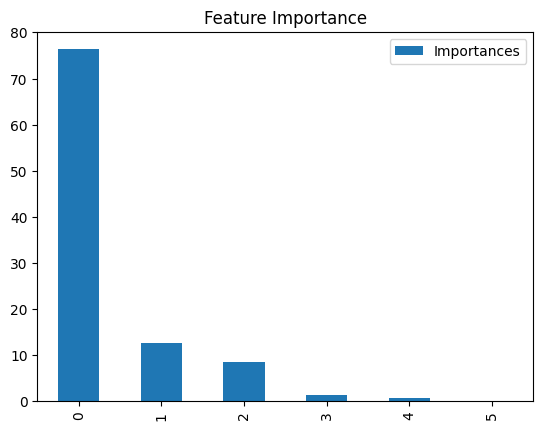

In [85]:
# Plot feature importances
model.get_feature_importance(prettified=True).plot(kind='bar', title='Feature Importance')

### Loss function change

The non default feature importance approximates how much the optimized loss function will change if the value of the feature changes.
This importances might be negative if the feature has bad influence on the loss function.
The importances are not normalized, the absolute value of the importance has the same scale as the optimized loss value.
To calculate this importance value you need to pass train_pool as an argument.

In [86]:
np.array(model.get_feature_importance(
    train_pool,
    type='LossFunctionChange',
    prettified=True
))

array([['smoker', 6262.829741268003],
       ['age', 1292.5628566317873],
       ['bmi', 959.5073119629296],
       ['children', 87.2395469076614],
       ['region', 22.088282256054754],
       ['sex', 5.413669543065225]], dtype=object)

In [87]:
# Compute the interaction strengths
interaction_strengths = model.get_feature_importance(
    train_pool,
    type='Interaction',
)

interaction_strengths

array([[0.        , 3.        , 8.89546955],
       [0.        , 5.        , 8.353932  ],
       [2.        , 5.        , 8.07461239],
       [0.        , 2.        , 7.67368015],
       [2.        , 3.        , 6.82609129],
       [3.        , 5.        , 6.73720189]])

### Shap values

In [88]:
print(model.predict([X.iloc[1,:]]))
print(model.predict([X.iloc[91,:]]))

[4599.29080154]
[12762.9175922]


In [89]:
shap_values = model.get_feature_importance(
    validation_pool,
    'ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(268, 6)


In [90]:
proba = model.predict([X.iloc[1,:]])[0]
raw = model.predict([X.iloc[1,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)

Probabilities 4599.290801539781
Raw formula value 4599.2908


In [91]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_test.iloc[1,:])

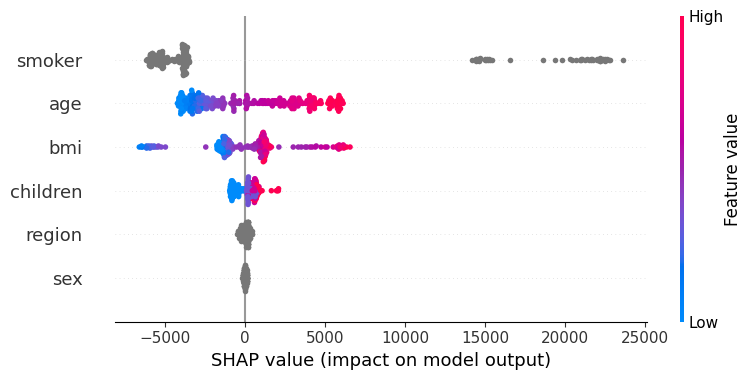

In [92]:
shap.summary_plot(shap_values, X_test)

## Snapshotting

The snapshotting feature in CatBoost is a very useful functionality that allows the training process to be paused and later resumed from the same point. This is particularly beneficial when training large models on extensive datasets, or in environments where long-running processes are subject to interruptions.

In [93]:
model = CatBoostRegressor(
    iterations=1000,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1
)

model.fit(train_pool, eval_set=validation_pool, verbose=10)

Learning rate set to 0.051465

bestTest = 3926.176388
bestIteration = 178

Shrink model to first 179 iterations.


## Saving the model

In [94]:
model = CatBoostRegressor(iterations=10)
model.fit(train_pool, eval_set=validation_pool, verbose=False)
model.save_model('catboost_model.bin')
model.save_model('catboost_model.json', format='json')

In [95]:
model.load_model('catboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'loss_function': 'RMSE', 'iterations': 10, 'verbose': 0}
0.5


## Training on GPU

In [96]:
%%time
from catboost import CatBoostRegressor


model = CatBoostRegressor(iterations=1000,
                           task_type="GPU",
                           devices='0')
model.fit(X_train,
          y_train,
          cat_features=cat_features,
          verbose=False)



CPU times: user 19.5 s, sys: 5.72 s, total: 25.2 s
Wall time: 25.6 s


## Missing values

In [97]:
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a simple dataset with missing values
data = {
    'Age': [25, np.nan, 35, 45, np.nan],  # Missing values in the 'Age' feature
    'Salary': [50000, 60000, np.nan, 70000, 80000],  # Missing values in the 'Salary' feature
    'Target': [1, 0, 1, 0, 1]
}

df = pd.DataFrame(data)

df

,Age,Salary,Target
0,25.0,50000.0,1
1,NaN,60000.0,0
2,35.0,NaN,1
3,45.0,70000.0,0
4,NaN,80000.0,1


In [98]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Target', axis=1),
    df['Target'],
    test_size=0.2,
    random_state=42
)

# Initialize a CatBoost classifier
model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.5,
    depth=2,
    verbose=False
)

# Train the model directly on data with missing values
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
print("Predictions:", predictions)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)



Predictions: [1]
Accuracy: 0.0
